In [2]:
import nilearn
from nibabel.testing import data_path
from nilearn import datasets, plotting, regions
import brainspace
import pandas as pd
import numpy as np
import seaborn as sns
#import os
import nibabel as nib
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
#import scipy.io as sio
#from nilearn.image import index_img
#from scipy.stats import ttest_ind
#import mvlearn
InteractiveShell.ast_node_interactivity = "all"
#import hcp_utils as hcp

In [28]:
def get_corticalVertices(data):
	""" Get indices of Cortex Data from cifti file """
	cifti=nib.load(data)
	structMap=cifti.header.get_index_map(1)
	brainModels=list(structMap.brain_models)
	LCrtBM=brainModels[0]
	Lcrt_vrts=np.array(LCrtBM.vertex_indices)
	LnumVerts=LCrtBM.surface_number_of_vertices
	
	RCrtBM=brainModels[1]
	Rcrt_vrts=np.array(RCrtBM.vertex_indices)
	RnumVerts=RCrtBM.surface_number_of_vertices
	
	return {'lIDX':Lcrt_vrts,'lnverts':LnumVerts,'rIDX':Rcrt_vrts,'rnverts':RnumVerts}
	

In [ ]:
subj = "A00038624"
anatdir="/Users/VictoriaShevchenko/Documents/PhD/COBRE/fmriprep-sub-A00038624/ses-20130101/anat"
fdir="/Users/VictoriaShevchenko/Documents/PhD/COBRE/fmriprep-sub-A00038624/ses-20130101/func"

Lsrf32="/Users/VictoriaShevchenko/Documents/PhD/HCP/surfaces/tpl-fsLR_den-32k_hemi-L_midthickness.surf.gii"
LsrfNative=f'{anatdir}/sub-A00038624_ses-20130101_acq-mprage_hemi-L_midthickness.surf.gii'

Rsrf32="/Users/VictoriaShevchenko/Documents/PhD/HCP/surfaces/tpl-fsLR_den-32k_hemi-R_midthickness.surf.gii"
RsrfNative=f'{anatdir}/sub-A00038624_ses-20130101_acq-mprage_hemi-R_midthickness.surf.gii'

In [15]:
subj_surf_ts_s1 = nib.load("sub-A00000541/ses-20100101/func/sub-A00000541_ses-20100101_task-rest_space-fsLR_den-91k_bold.dtseries.nii").get_fdata()
subj_surf_ts_s2 = nib.load("sub-A00000541/ses-20110101/func/sub-A00000541_ses-20110101_task-rest_space-fsLR_den-91k_bold.dtseries.nii").get_fdata()

In [24]:
from nilearn.interfaces.fmriprep import load_confounds_strategy

confounds_out_s1 = load_confounds_strategy("sub-A00000541/ses-20100101/func/sub-A00000541_ses-20100101_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz", denoise_strategy = "simple")
confounds_out_s2 = load_confounds_strategy("sub-A00000541/ses-20110101/func/sub-A00000541_ses-20110101_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz", denoise_strategy = "simple")
confounds_out = np.concatenate([confounds_out_s1[0], confounds_out_s2[0]])

In [25]:
all_ts = np.concatenate([subj_surf_ts_s1, subj_surf_ts_s2])


In [27]:
from nilearn import signal

clean_ts = signal.clean(all_ts, confounds = confounds_out)

In [29]:
cortex_indices = get_corticalVertices("sub-A00000541/ses-20100101/func/sub-A00000541_ses-20100101_task-rest_space-fsLR_den-91k_bold.dtseries.nii")

In [30]:
cortex_indices = np.concatenate([cortex_indices["lIDX"], cortex_indices["rIDX"]])

In [ ]:
clean_ts = clean_ts[:, cortex_indices]

In [31]:
cortex_indices.shape

(59412,)

In [22]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([clean_ts])[0]

KeyboardInterrupt: 

In [5]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlations_control_z = []

correlation_matrix = correlation_measure.fit_transform([all_ts])[0]
correlation_matrix_z = np.arctanh(correlation_matrix)
correlations_control_z.append(correlation_matrix_z)
    
    
mean_correlations_control_z = np.mean(correlations_control_z, axis=0)
mean_conn_control_standardized = np.tanh(mean_correlations_control_z)
np.fill_diagonal(mean_conn_control_standardized, 0)


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_47664/1668791667.py:20: RuntimeWarning: divide by zero encountered in arctanh
  correlation_matrix_z = np.arctanh(correlation_matrix)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_47664/1668791667.py:20: RuntimeWarning: divide by zero encountered in arctanh
  correlation_matrix_z = np.arctanh(correlation_matrix)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_47664/1668791667.py:20: RuntimeWarning: divide by zero encountered in arctanh
  correlation_matrix_z = np.arctanh(correlation_matrix)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_47664/1668791667.py:20: RuntimeWarning: divide by zero encountered in arctanh
  correlation_matrix_z = np.arctanh(correlation_matrix)


In [6]:
subjects_mdd = ['02', '03', '04', '05']
correlations_mdd_z = []

for subject in subjects_mdd:
    confounds_minimal_no_gsr, sample_mask = fmriprep.load_confounds(
    "/Users/VictoriaShevchenko/Documents/PhD/rus_depression/derivatives/sub-%s/func/sub-%s_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz" % (subject, subject),
    strategy=["high_pass", "motion", "wm_csf", "global_signal"],
    motion="basic", wm_csf="basic", global_signal="basic")
    
    time_series = masker.fit_transform("/Users/VictoriaShevchenko/Documents/PhD/rus_depression/derivatives/sub-%s/func/sub-%s_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz" % (subject, subject),
                                   confounds=confounds_minimal_no_gsr,
                                   sample_mask=sample_mask)
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    correlation_matrix_z = np.arctanh(correlation_matrix)
    correlations_mdd_z.append(correlation_matrix_z)
    
mean_correlations_mdd_z = np.mean(correlations_mdd_z, axis=0)
mean_conn_mdd_standardized = np.tanh(mean_correlations_mdd_z)
np.fill_diagonal(mean_conn_mdd_standardized, 0)


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_47664/1284693059.py:14: RuntimeWarning: divide by zero encountered in arctanh
  correlation_matrix_z = np.arctanh(correlation_matrix)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_47664/1284693059.py:14: RuntimeWarning: divide by zero encountered in arctanh
  correlation_matrix_z = np.arctanh(correlation_matrix)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_47664/1284693059.py:14: RuntimeWarning: divide by zero encountered in arctanh
  correlation_matrix_z = np.arctanh(correlation_matrix)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_47664/1284693059.py:14: RuntimeWarning: divide by zero encountered in arctanh
  correlation_matrix_z = np.arctanh(correlation_matrix)


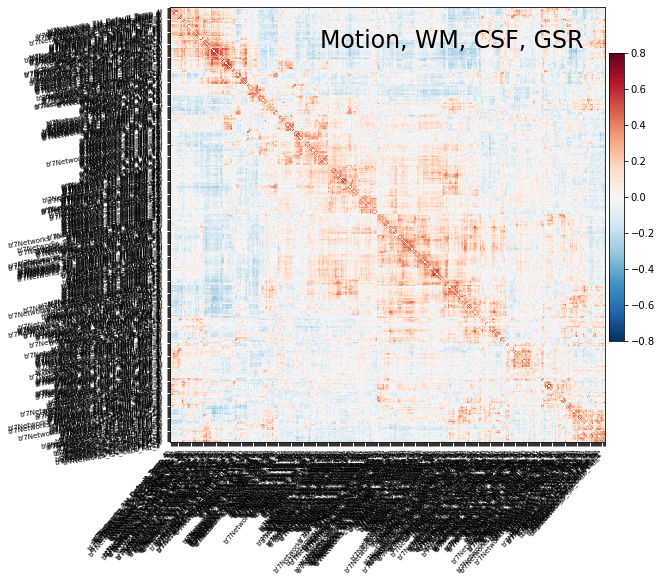

In [6]:
%matplotlib inline
plotting.plot_matrix(mean_conn_control_standardized, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, title='Motion, WM, CSF, GSR',
                     reorder=True)


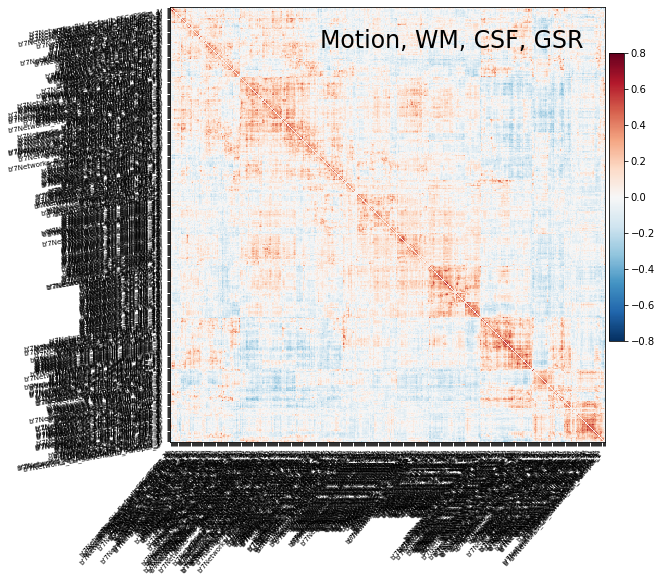

In [7]:
%matplotlib inline
plotting.plot_matrix(mean_conn_mdd_standardized, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, title='Motion, WM, CSF, GSR',
                     reorder=True)


In [7]:
from brainspace.gradient import GradientMaps
gm = GradientMaps(n_components=3, approach='dm', kernel='pearson', alignment = "procrustes")
#gm = GradientMaps(approach='dm', kernel='pearson', alignment = "procrustes")




In [8]:
string_labels = []
for label in labels[1:]:
    string_label = label.decode("utf-8")
    string_labels.append(string_label)

In [10]:
import re
networks = "Vis|SomMot|DorsAttn|SalVentAttn|Limbic|Cont|Default"
network_labels = []
for label in string_labels:
    network_labels.append(re.findall(networks, label)[0])
    

In [8]:
from brainspace.datasets import load_parcellation
labeling = load_parcellation('schaefer', scale=400, join=True)


In [9]:
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres
surf_lh, surf_rh = load_conte69()

In [10]:
gm.fit([mean_conn_control_standardized, mean_conn_mdd_standardized])

GradientMaps(alignment='procrustes', kernel='pearson', n_components=3)

In [11]:
from brainspace.utils.parcellation import map_to_labels
grad_control = [None] * 3
for i, g in enumerate(gm.aligned_[0].T):
    grad_control[i] = map_to_labels(g, labeling, mask=labeling != 0, fill=np.nan)

In [12]:
grad_mdd = [None] * 3
for i, g in enumerate(gm.aligned_[1].T):
    grad_mdd[i] = map_to_labels(g, labeling, mask=labeling != 0, fill=np.nan)

In [13]:
labeling.shape

(64984,)

/Users/VictoriaShevchenko/opt/anaconda3/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


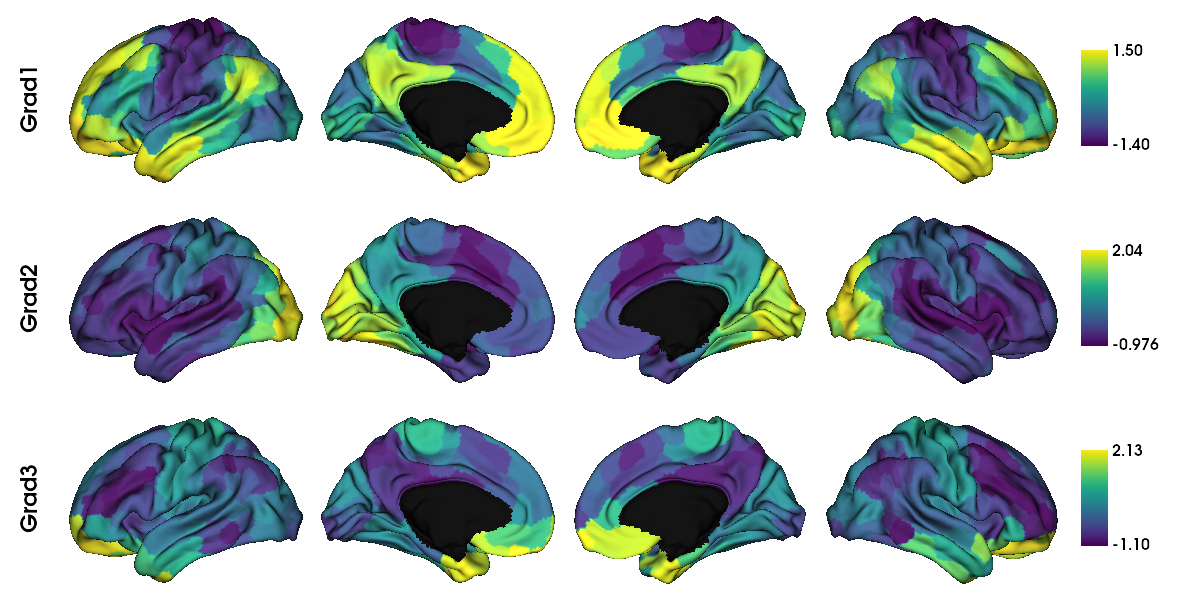

In [16]:
plot_hemispheres(surf_lh, surf_rh, array_name=grad_control, size=(1200, 600), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3'], zoom=1.5, embed_nb = True)


In [ ]:
plot_hemispheres(surf_lh, surf_rh, array_name=grad_control, size=(1200, 600), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3'], zoom=1.5, embed_nb = True)

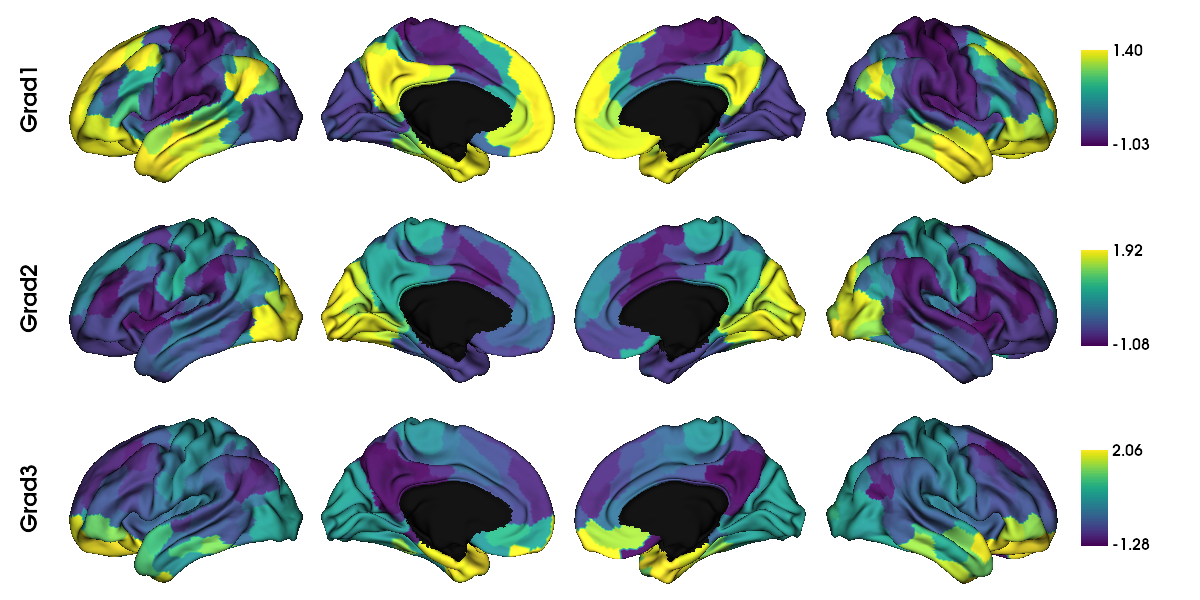

In [19]:
plot_hemispheres(surf_lh, surf_rh, array_name=grad_mdd, size=(1200, 600), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3'], zoom=1.5, embed_nb = True)


In [14]:
grad_control_df = pd.DataFrame(np.array(grad_control).T, columns = ["Grad 1", "Grad 2", "Grad 3"])
#grad_control_df["Network"] = network_labels
grad_mdd_df = pd.DataFrame(np.array(grad_mdd).T, columns = ["Grad 1", "Grad 2", "Grad 3"])
#grad_mdd_df["Network"] = network_labels


In [15]:
grad_control_df

Grad 1    Grad 2    Grad 3
0      1.181922  0.402953 -0.660669
1     -1.335934 -0.224254  0.883634
2     -1.007951 -0.164312  0.412713
3      1.220200 -0.492197  0.220665
4     -0.315390  1.994808  0.202142
...         ...       ...       ...
64979  1.218336 -0.398989  1.160219
64980  0.970074 -0.480798 -0.054768
64981  0.393939 -0.041510 -1.017653
64982  0.393939 -0.041510 -1.017653
64983  0.393939 -0.041510 -1.017653

[64984 rows x 3 columns]

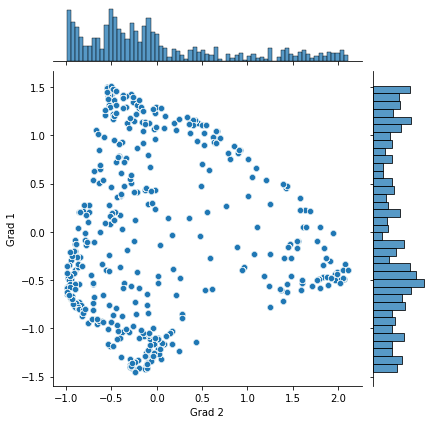

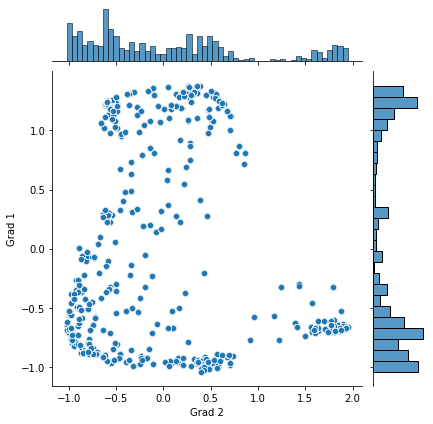

In [15]:

sns.jointplot(data = grad_control_df, x = "Grad 2", y = "Grad 1") #, hue = "Grad 1", palette = "viridis"
sns.jointplot(data = grad_mdd_df, x = "Grad 2", y = "Grad 1") #, hue = "Grad 1", palette = "viridis"


In [ ]:
yeo_atlas = nilearn.datasets.fetch_atlas_yeo_2011()

In [ ]:
import nibabel
yeo_atlas  = nibabel.load("/Users/VictoriaShevchenko/Documents/PhD/yeo_parc/CIFTI2-RSN-networks.32k_fs_LR.dlabel.nii")


<AxesSubplot:xlabel='Grad 3', ylabel='Grad 1'>

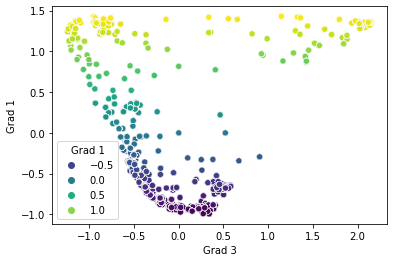

In [43]:
sns.scatterplot(x = grad_mdd_df["Grad 2"], y = grad_mdd_df["Grad 1"])



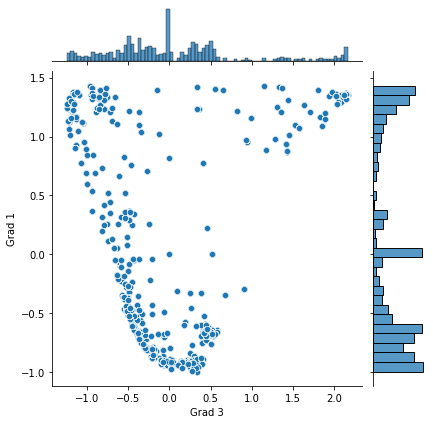

In [44]:
sns.jointplot(x = grad_mdd_df["Grad 3"], y = grad_mdd_df["Grad 1"])


Generating random data for visualization

In [19]:
N = 1000
variance_explained_hc = np.random.normal(0.20, 0.05, N)
variance_explained_mdd = np.random.normal(0.195, 0.05, N)
variance_explained_ocd = np.random.normal(0.178, 0.05, N)
variance_explained_bd = np.random.normal(0.169, 0.05, N)
variance_explained_scz = np.random.normal(0.155, 0.05, N)
variance_explained_autism = np.random.normal(0.12, 0.05, N)

variance_explained = np.concatenate((variance_explained_hc, variance_explained_mdd, variance_explained_ocd, variance_explained_bd, variance_explained_scz, variance_explained_autism))



In [9]:
hc_labels = np.empty([1, N], dtype='U25')
mdd_labels = np.empty([1, N], dtype='U25')
ocd_labels = np.empty([1, N], dtype='U25')
bd_labels = np.empty([1, N], dtype='U25')
scz_labels = np.empty([1, N], dtype='U25')
autism_labels = np.empty([1, N], dtype='U25')
hc_labels[:] = "HC"
mdd_labels[:] = "MDD"
ocd_labels[:] = "OCD"
bd_labels[:] = "BD"
scz_labels[:] = "SCZ"
autism_labels[:] = "Autism"

group_labels = np.concatenate((hc_labels, mdd_labels, ocd_labels, bd_labels, scz_labels, autism_labels))
group_labels = group_labels.flatten()

In [25]:
df_fake = pd.DataFrame({"% Var Explained, Principal Gradient" : variance_explained, "Group":group_labels})
df_fake

% Var Explained, Principal Gradient   Group
0                                0.183269      HC
1                                0.242254      HC
2                                0.208159      HC
3                                0.193339      HC
4                                0.141195      HC
...                                   ...     ...
5995                             0.061604  Autism
5996                             0.052345  Autism
5997                             0.142294  Autism
5998                             0.155478  Autism
5999                             0.089175  Autism

[6000 rows x 2 columns]

In [20]:
hyp_plot = sns.violinplot(x = df_fake["Group"], y = df_fake["% Var Explained, Principal Gradient"])
hyp_plot.axhline(0.2, color = "black", linestyle = "--")
plt.show()

NameError: name 'df_fake' is not defined

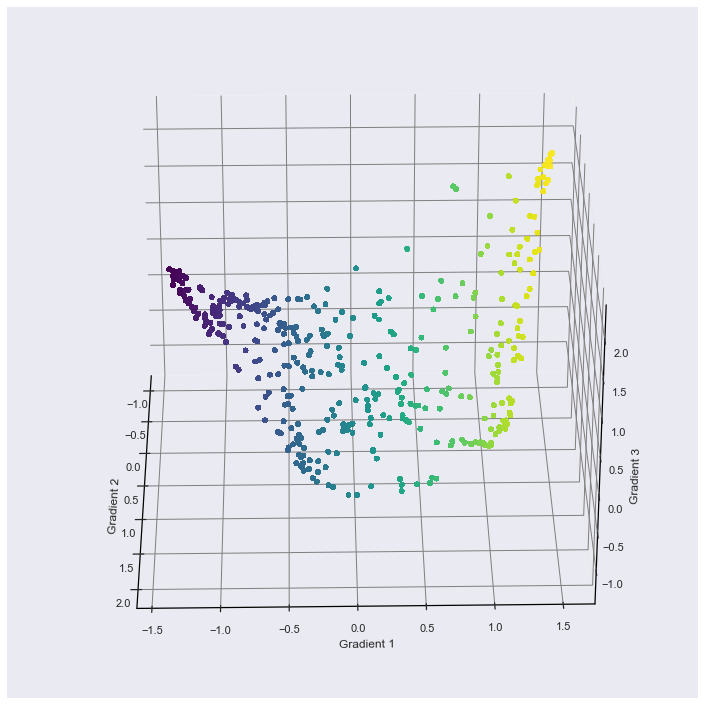

In [93]:
%matplotlib inline

import mpl_toolkits
from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"] = 12.8, 9.6

fig = plt.figure()
ax = Axes3D(fig)

def init():
   ax.scatter(grad_control_df["Grad 2"], grad_control_df["Grad 1"], grad_control_df["Grad 3"], cmap='viridis', linewidth=0.5, c = grad_control_df["Grad 1"])
   ax.xaxis.pane.fill = False
   ax.yaxis.pane.fill = False
   ax.zaxis.pane.fill = False
   ax.w_xaxis.line.set_color("black")
   ax.w_yaxis.line.set_color("black")
   ax.w_zaxis.line.set_color("black")
   ax.xaxis._axinfo["grid"]['color'] =  ("grey")
   ax.yaxis._axinfo["grid"]['color'] =  ("grey")
   ax.zaxis._axinfo["grid"]['color'] =  ("grey")
   ax.set_xlabel('Gradient 2')
   ax.set_ylabel('Gradient 1')
   ax.set_zlabel('Gradient 3')
   return fig,

def animate(i):
    ax.view_init(elev=30., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
writergif = animation.PillowWriter(fps=30)                       
# Save
anim.save('3Dgradient.gif', writer=writergif)

Text(0.5, 0, 'Gradient 2')

Text(0.5, 0, 'Gradient 1')

Text(0.5, 0, 'Gradient 3')

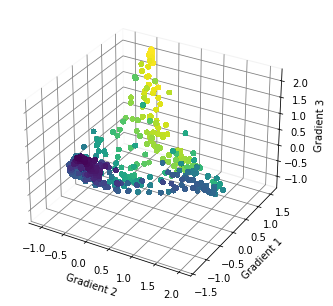

In [16]:

from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

fig = plt.figure()
ax = Axes3D(fig)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.w_xaxis.line.set_color("black")
ax.w_yaxis.line.set_color("black")
ax.w_zaxis.line.set_color("black")

ax.xaxis._axinfo["grid"]['color'] =  ("grey")
ax.yaxis._axinfo["grid"]['color'] =  ("grey")
ax.zaxis._axinfo["grid"]['color'] =  ("grey")

#cmap = ListedColormap(sns.color_palette("viridis", 256).as_hex())

gradient_3d = ax.scatter(grad_control_df["Grad 2"], grad_control_df["Grad 1"], grad_control_df["Grad 3"], cmap='viridis', linewidth=0.5, c = grad_control_df["Grad 1"], alpha = 1)

# Get rid of the panes                          

ax.set_xlabel('Gradient 2')
ax.set_ylabel('Gradient 1')
ax.set_zlabel('Gradient 3')

# legend
#plt.legend(*gradient_3d.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

In [16]:
grad_mdd_df["Group"] = "MDD"
grad_control_df["Group"] = "HC"
gradients = pd.concat([grad_mdd_df, grad_control_df])

In [1]:
len(grad_control_df)


KeyboardInterrupt



In [17]:
gradients.reset_index(level=0, inplace=True)
gradients = gradients.loc[:, gradients.columns != "index"]

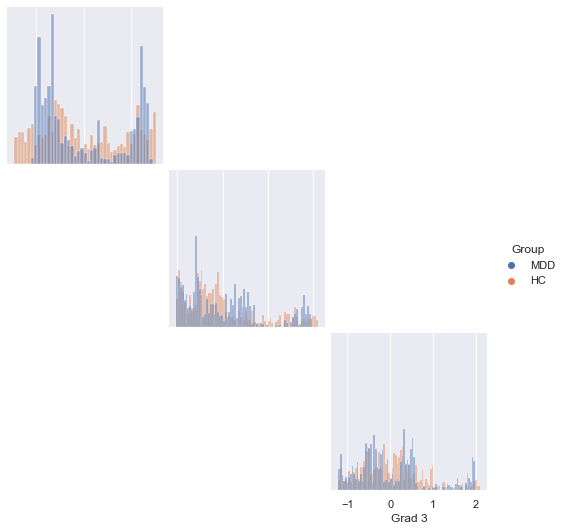

In [18]:
sns.set(rc={'figure.facecolor':'white'})
import matplotlib.pyplot as plt
g = sns.pairplot(gradients, hue = "Group", diag_kind="hist", corner = True)
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

g.map_upper(hide_current_axis)
g.map_lower(hide_current_axis)

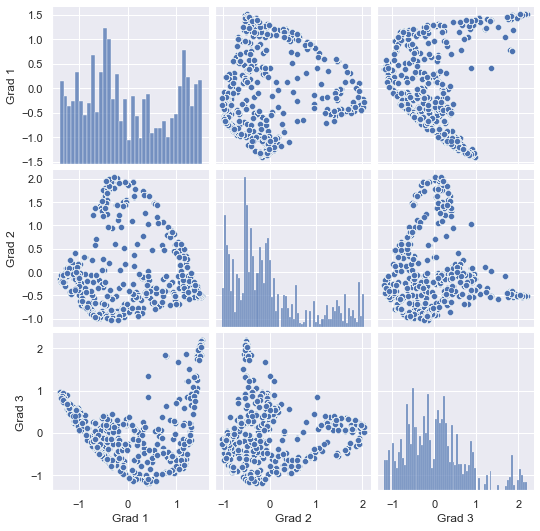

In [37]:
sns.pairplot(grad_control_df)

In [19]:
import math
vertex_density_1grad = []
for score in grad_control[0]:
    distance = []
    for index_shift in [-3, -2, -1, 1, 2, 3]:
        if math.isnan(score) == True:
            distance.append(np.nan)
        else:
            next_score = grad_control[0][list(grad_control[0]).index(score) + index_shift]
            if np.isnan(next_score) == True:
                next_score = 0
            distance.append(abs(score - next_score))
    distance = np.sum(distance)/len(distance)
    vertex_density_1grad.append(distance)

In [22]:
vertex_density_1grad_mdd = []
for score in grad_mdd[0]:
    distance = []
    for index_shift in [-3, -2, -1, 1, 2, 3]:
        if math.isnan(score) == True:
            distance.append(np.nan)
        else:
            next_score = grad_mdd[0][list(grad_mdd[0]).index(score) + index_shift]
            if np.isnan(next_score) == True:
                next_score = 0
            distance.append(abs(score - next_score))
    distance = np.sum(distance)/len(distance)
    vertex_density_1grad_mdd.append(distance)

In [20]:
vertex_density_control = np.empty((3, 64984))
vertex_density_control[:] = np.nan
vertex_density_control[0] = vertex_density_1grad

In [26]:
vertex_density_mdd = np.empty((3, 64984))
vertex_density_mdd[:] = np.nan
vertex_density_mdd[0] = vertex_density_1grad_mdd

/Users/VictoriaShevchenko/opt/anaconda3/lib/python3.8/site-packages/brainspace/plotting/utils.py:303: RuntimeWarning: All-NaN axis encountered
  a, b = np.nanmin(x), np.nanmax(x)
/Users/VictoriaShevchenko/opt/anaconda3/lib/python3.8/site-packages/brainspace/plotting/utils.py:367: RuntimeWarning: All-NaN slice encountered
  specs['min'][:] = np.nanmin(specs['min'], axis=ax, keepdims=True)
/Users/VictoriaShevchenko/opt/anaconda3/lib/python3.8/site-packages/brainspace/plotting/utils.py:368: RuntimeWarning: All-NaN slice encountered
  specs['max'][:] = np.nanmax(specs['max'], axis=ax, keepdims=True)
/Users/VictoriaShevchenko/opt/anaconda3/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


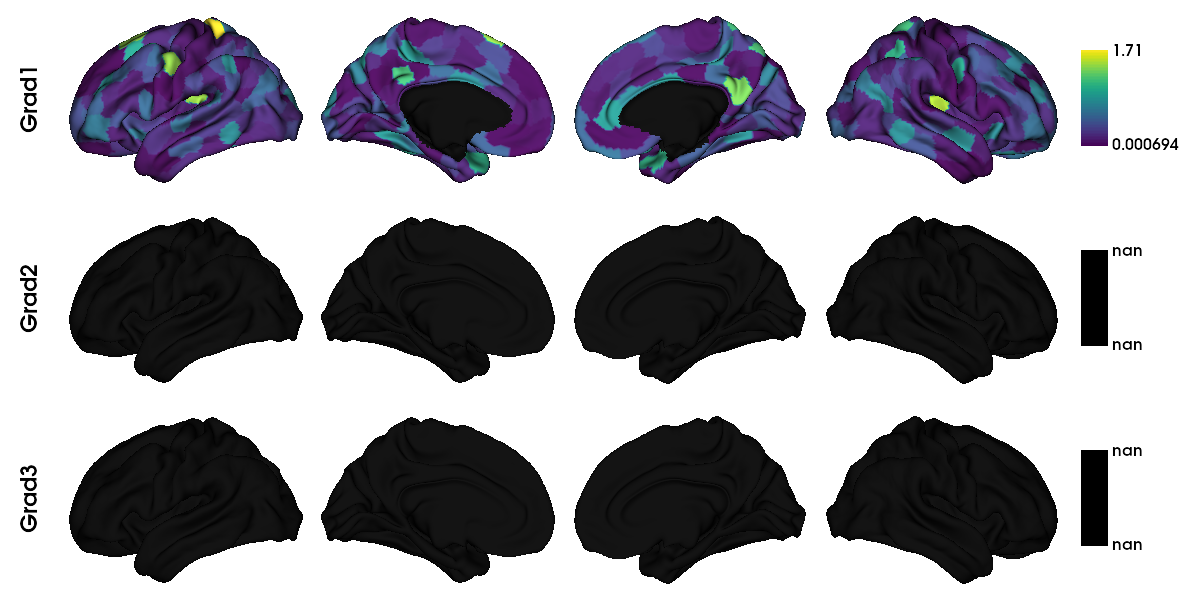

In [21]:
plot_hemispheres(surf_lh, surf_rh, array_name=vertex_density_control, size=(1200, 600), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3'], zoom=1.5, embed_nb = True)

/Users/VictoriaShevchenko/opt/anaconda3/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


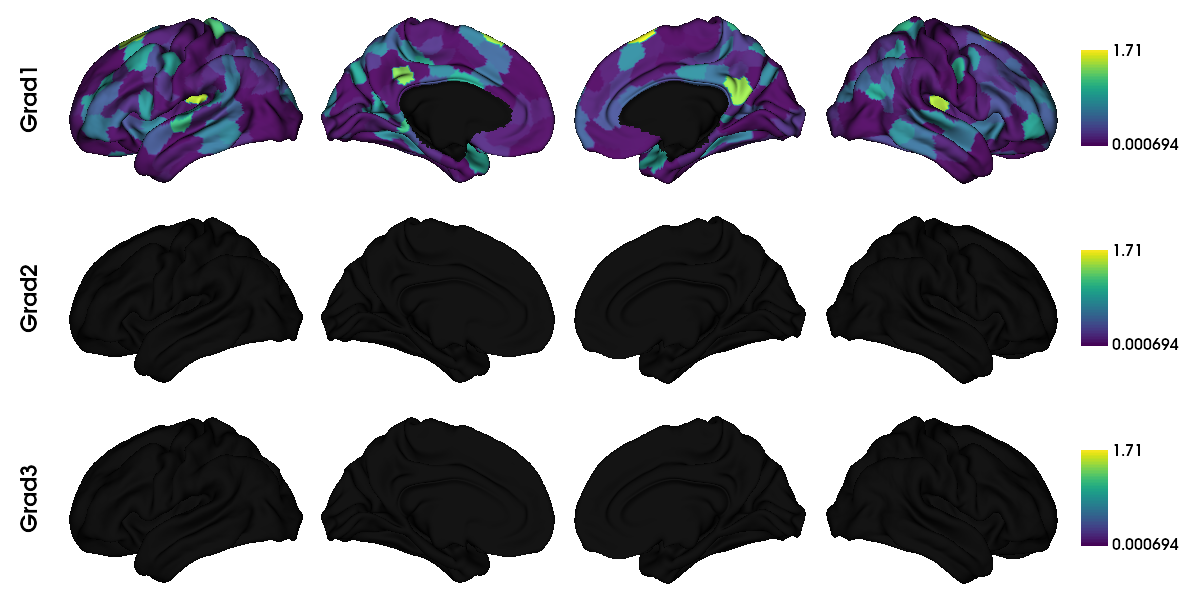

In [29]:
plot_hemispheres(surf_lh, surf_rh, array_name=vertex_density_mdd, size=(1200, 600), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3'], zoom=1.5, embed_nb = True, color_range= (0.000694, 1.71))

In [102]:
len(vertex_density_1grad)
len(grad_control[0])

50658

64984

In [98]:
grad_control[0][7]
1.5 - grad_control[0][list(grad_control[0]).index(0.878203770556897) + 3]
list(grad_control[0]).index(1.080553189020806) + 1

nan

0.621796229443103

72

In [92]:
list(grad_control[0]).index(score).isnan

0.878203770556897

list

[0.419446810979194]

list